<a href="https://colab.research.google.com/github/JamilyaSultan/INDE-597-Deep-and-Reinforcement-Learning/blob/main/Copy_of_Taxicab_gym_env.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import gym
import numpy as np
import numpy.random as random
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme()

---


## The Gym Environment

The core gym interface is ``env``, which is the unified environment interface. The following list shows the basic ``env`` methods:

1. ``env.reset()``: Resets the environment and returns a random initial state.

2. ``env.step(action)``: Step the environment by one timestep. Returns

 - observation (object): This is the current state of the environment and is an environment-specific object representing your observation of the environment. For example, pixel data from a camera, joint angles and joint velocities of a robot, or the board state in a board game.

 - reward (float): amount of reward achieved by the previous action. The scale varies between environments, but the goal is always to increase your total reward.

 - done (boolean): whether it’s time to reset the environment again. Most (but not all) tasks are divided up into well-defined episodes, and done being True indicates the episode has terminated. (For example, perhaps the pole tipped too far, or you lost your last life.)

 - info (dict): diagnostic information useful for debugging. It can sometimes be useful for learning (for example, it might contain the raw probabilities behind the environment’s last state change). However, official evaluations of your agent are not allowed to use this for learning.

7. ``env.render()``: Renders one frame of the environment (helpful in visualizing the environment)



We can best illustrate these notions with an example such as the Taxi-v3 environment. 

---

## The Taxi-v3 environment

There are 4 locations (labeled by different letters), and our job is to pick up the passenger at one location and drop him off at another. We receive +20 points for a successful drop-off and lose 1 point for every time-step it takes. There is also a 10 point penalty for illegal pick-up and drop-off actions

* Observations: There are 500 discrete states since there are 25 taxi positions, 5 possible locations of the passenger (including the case when the passenger is in the taxi), and 4 destination locations. 
   
* Passenger locations:
 - 0: R(ed)
 - 1: G(reen)
 - 2: Y(ellow)
 - 3: B(lue)
 - 4: in taxi
  
* Destinations:
 - 0: R(ed)
 - 1: G(reen)
 - 2: Y(ellow)
 - 3: B(lue)
   
* Actions: There are 6 discrete deterministic actions:
 - 0: move south
 - 1: move north
 - 2: move east
 - 3: move west
 - 4: pickup passenger
 - 5: drop off passenger
 
* Rewards: There is a default per-step reward of -1, except for delivering the passenger, which is +20, or executing "pickup" and "drop-off" actions illegally, which is -10.

* Rendering:
 - blue: passenger
 - magenta: destination
 - yellow: empty taxi
 - green: full taxi
 - other letters (R, G, Y and B): locations for passengers and destinations
   
* state space is represented by: (taxi_row, taxi_col, passenger_location, destination)




----

In [ ]:
env = gym.make("Taxi-v3")
env.reset()
env.render()

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+



---

## SARSA

$$
Q(s, a) \leftarrow Q(s, a) + \alpha\Big[r + \gamma Q(s', a') - Q(s, a) \Big ]
$$

---

In [ ]:
def sarsa(env, iterations = 1_000, gamma = 0.7, alpha = 0.2, epsilon = 0.1):
    # initialize Q-table 
    Q = np.zeros([env.observation_space.n, env.action_space.n])
    # store episode total rewards in R for plotting purposes 
    R = []
    for episode in range(iterations):
        done = False
        total_reward = 0
        current_state = env.reset()
        # the following if-else statement is epsilon-greedy policy
        if random.uniform(0, 1) < epsilon: # explore
            current_action = env.action_space.sample()
        else: # exploit
            current_action = np.argmax(Q[current_state])
        # start episode state, action, reward, state sequence  
        while not done:
            next_state, reward, done, _ = env.step(current_action)
            # the following if-else statement is epsilon-greedy policy
            if random.uniform(0, 1) < epsilon:
                next_action = env.action_space.sample() # explore
            else:
                next_action = np.argmax(Q[next_state]) # exploit
            
            sarsa_value = Q[next_state, next_action]
            old_value = Q[current_state, current_action]

            new_value = old_value + alpha*(reward + gamma*sarsa_value - old_value)

            Q[current_state, current_action] = new_value

            total_reward += reward
            current_state = next_state
            current_action = next_action
        R.append(total_reward)
        if episode % 100 == 0:
            print(f"Episode: {episode}, Total Reward: {total_reward}")
        
    return Q, R

In [ ]:
Q, R = sarsa(env, iterations = 1_000, gamma = 0.9, alpha = 0.01)

Episode: 0, Total Reward: -695
Episode: 100, Total Reward: -245
Episode: 200, Total Reward: -290
Episode: 300, Total Reward: -254
Episode: 400, Total Reward: -326
Episode: 500, Total Reward: -245
Episode: 600, Total Reward: -299
Episode: 700, Total Reward: -215
Episode: 800, Total Reward: -272
Episode: 900, Total Reward: -79


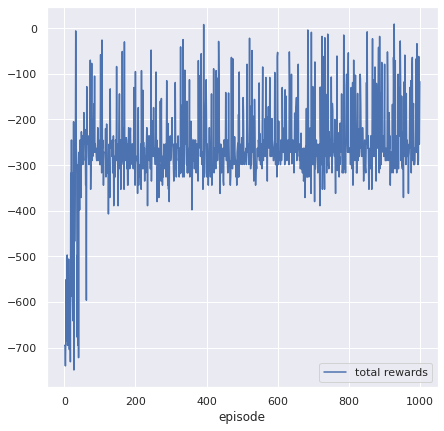

In [ ]:
plt.figure(figsize = (7, 7))
plt.plot(range(1, len(R) + 1), R, label = "total rewards")
plt.xlabel("episode")
plt.legend()
plt.show()

In [ ]:
from IPython.display import clear_output
from time import sleep

def print_frames(frames):
    for i, frame in enumerate(frames):
        clear_output(wait=True)
        print(frame['frame'])
        #print(frame['frame'].getvalue())
        print(f"Timestep: {i + 1}")
        print(f"State: {frame['state']}")
        print(f"Action: {frame['action']}")
        print(f"Reward: {frame['reward']}")
        sleep(.1)

In [ ]:
"""Evaluate agent's performance after SARSA-learning"""

total_epochs, total_penalties = 0, 0
episodes = 2
frames = []
for _ in range(episodes):
    state = env.reset() # the initial state is random 
    epochs, penalties, reward = 0, 0, 0
    done = False
    while not done:
        action = np.argmax(Q[state]) #using the Q-table that we learned with SARSA
        state, reward, done, info = env.step(action)
        if reward == -10:
            penalties += 1
        # Put each rendered frame into dict for animation
        frames.append({
            'frame': env.render(mode='ansi'),
            'state': state,
            'action': action,
            'reward': reward
                            }
            )
        epochs += 1

    total_penalties += penalties
    total_epochs += epochs

print(f"Results after {episodes} episodes:")
print(f"Average timesteps per episode: {total_epochs / episodes}")
print(f"Average penalties per episode: {total_penalties / episodes}")

Results after 2 episodes:
Average timesteps per episode: 200.0
Average penalties per episode: 0.0


In [ ]:
print_frames(frames)

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (East)

Timestep: 400
State: 189
Action: 2
Reward: -1



---
 ## Problems. 

 1. Write a $Q$-learning function to solve the reinforcement learning problem on the taxicab problem. Recall, the $Q$-learning update rule is:
$$
Q(s, a) \leftarrow Q(s, a) + \alpha\Big[r + \gamma \max_{a}Q(s', a) - Q(s, a) \Big ]
$$
Write this function in a similar manor to that of sarsa above. 

 2. In Taxi world, which is better: SARSA or $Q$-learning? How do you know? On what criteria do you measure algorithm quality? 

 3. The environment is initialized randomly each time. This makes it hard to compare the two algorithms if each run is different, and it complicates debugging. Make a deterministic version of the algorithms for comparison, where each starts at the same configuration. Hint: instead of setting ```current_state = env.reset()```, first call ```env.reset()``` and then set the variable ```current_state``` equal to the same state. 

 4. Experiment with different values for $\epsilon$, $\alpha$, and $\gamma$. Which are better? Experiment with decaying values of $\epsilon$, $\alpha$, and $\gamma$.

 5. Go to Gym, and look for the Mountain Car example; see this [link](https://www.gymlibrary.ml/environments/classic_control/mountain_car/?highlight=mountain+car). Compare SARSA and $Q$-learning. Which learns faster, and what about solution quality? 




---



In [ ]:
def Qlearning(env, iterations = 1_000, gamma = 0.7, alpha = 0.2, epsilon = 0.1):
    # initialize Q-table 
    Q = np.zeros([env.observation_space.n, env.action_space.n])
    # store episode total rewards in R for plotting purposes 
    R = []
    for episode in range(iterations):
        done = False
        total_reward = 0
        current_state = env.reset()
        # the following if-else statement is epsilon-greedy policy
        if random.uniform(0, 1) < epsilon: # explore
            current_action = env.action_space.sample()
        else: # exploit
            current_action = np.argmax(Q[current_state])
        # start episode state, action, reward, state sequence  
        while not done:
            next_state, reward, done, _ = env.step(current_action)
            # the following if-else statement is epsilon-greedy policy
            if random.uniform(0, 1) < epsilon:
                next_action = env.action_space.sample() # explore
            else:
                next_action = np.argmax(Q[next_state]) # exploit
            
            sarsa_value = Q[next_state, next_action]
            old_value = Q[current_state, current_action]

            new_value = old_value + alpha*(reward + gamma*np.argmax(Q[next_action]) - old_value)

            Q[current_state, current_action] = new_value

            total_reward += reward
            current_state = next_state
            current_action = next_action
        R.append(total_reward)
        if episode % 100 == 0:
            print(f"Episode: {episode}, Total Reward: {total_reward}")
        
    return Q, R

In [ ]:
Q1, R1 = Qlearning(env, iterations = 1_000, gamma = 0.9, alpha = 0.01)

Episode: 0, Total Reward: -749
Episode: 100, Total Reward: -245
Episode: 200, Total Reward: -308
Episode: 300, Total Reward: -245
Episode: 400, Total Reward: -308
Episode: 500, Total Reward: -263
Episode: 600, Total Reward: -218
Episode: 700, Total Reward: -263
Episode: 800, Total Reward: -254
Episode: 900, Total Reward: -236


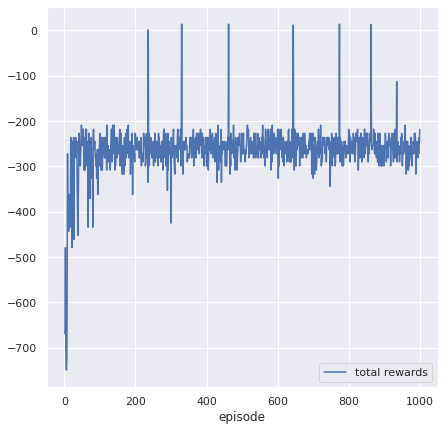

In [ ]:
plt.figure(figsize = (7, 7))
plt.plot(range(1, len(R1) + 1), R1, label = "total rewards")
plt.xlabel("episode")
plt.legend()
plt.show()

Difference between Sarsa and Q-learning amounts into how you select your next best action, which from an algorithmic standpoint can be a mean, max or best action depending on how you chose to implement it.

Here’s a simple way to think about the distinction between the on-policy vs off-policy learning. Any RL agent can have two policies: behavior and learning. The behavior policy is used for generating actions to interact with its environment by sampling it; the learning policy is what the agent learns by such interactions. In SARSA the two are equal; in off-policy methods, like Q-learning, they are not.

For Taxcab gym looking at the total rewards plot I would say that Q-learning learns quicker. Q-learning agent updates the value of its first action in state one after seeing the highest action possible in the second state.

In [ ]:
def Qlearning_det(env, iterations = 1_000, gamma = 0.7, alpha = 0.2, epsilon = 0.1):
    # initialize Q-table 
    Q = np.zeros([env.observation_space.n, env.action_space.n])
    # store episode total rewards in R for plotting purposes 
    R = []
    for episode in range(iterations):
        done = False
        total_reward = 0
        env.reset()
        current_state = env.reset()
        # the following if-else statement is epsilon-greedy policy
        if random.uniform(0, 1) < epsilon: # explore
            current_action = env.action_space.sample()
        else: # exploit
            current_action = np.argmax(Q[current_state])
        # start episode state, action, reward, state sequence  
        while not done:
            next_state, reward, done, _ = env.step(current_action)
            # the following if-else statement is epsilon-greedy policy
            if random.uniform(0, 1) < epsilon:
                next_action = env.action_space.sample() # explore
            else:
                next_action = np.argmax(Q[next_state]) # exploit
            
            sarsa_value = Q[next_state, next_action]
            old_value = Q[current_state, current_action]

            new_value = old_value + alpha*(reward + gamma*np.argmax(Q[next_action]) - old_value)

            Q[current_state, current_action] = new_value

            total_reward += reward
            current_state = next_state
            current_action = next_action
        R.append(total_reward)
        if episode % 100 == 0:
            print(f"Episode: {episode}, Total Reward: {total_reward}")
        
    return Q, R

In [ ]:
Q2, R2 = Qlearning_det(env, iterations = 1_000, gamma = 0.9, alpha = 0.01)

Episode: 0, Total Reward: -695
Episode: 100, Total Reward: -281
Episode: 200, Total Reward: -263
Episode: 300, Total Reward: -254
Episode: 400, Total Reward: -245
Episode: 500, Total Reward: -245
Episode: 600, Total Reward: -254
Episode: 700, Total Reward: -272
Episode: 800, Total Reward: -236
Episode: 900, Total Reward: -281


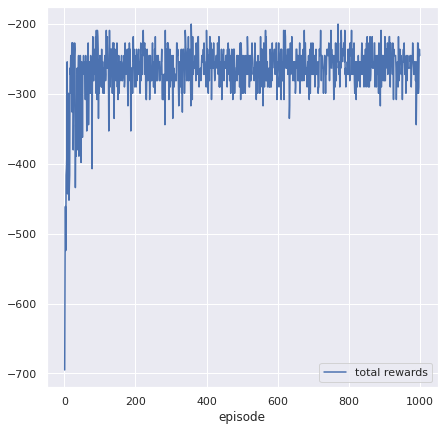

In [ ]:
plt.figure(figsize = (7, 7))
plt.plot(range(1, len(R2) + 1), R2, label = "total rewards")
plt.xlabel("episode")
plt.legend()
plt.show()

With deterministic version of the environment, the rewards improved.

In [ ]:
"""Evaluate agent's performance after Q-learning with random environment"""

total_epochs, total_penalties = 0, 0
episodes = 2
frames = []
for _ in range(episodes):
    state = env.reset() # the initial state is random 
    epochs, penalties, reward = 0, 0, 0
    done = False
    while not done:
        action = np.argmax(Q1[state]) #using the Q-table that we learned with Q-learning
        state, reward, done, info = env.step(action)
        if reward == -10:
            penalties += 1
        # Put each rendered frame into dict for animation
        frames.append({
            'frame': env.render(mode='ansi'),
            'state': state,
            'action': action,
            'reward': reward
                            }
            )
        epochs += 1

    total_penalties += penalties
    total_epochs += epochs

print(f"Results after {episodes} episodes:")
print(f"Average timesteps per episode: {total_epochs / episodes}")
print(f"Average penalties per episode: {total_penalties / episodes}")

Results after 2 episodes:
Average timesteps per episode: 200.0
Average penalties per episode: 0.0


In [ ]:
print_frames(frames)

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (East)

Timestep: 400
State: 284
Action: 2
Reward: -1



Probability epsilon:
We want the training process to let our agent explore the environment at the beginning, but we also want it to exploit the learnt model.
The ε parameter make this choice : it is near 1 at the beginning so that the probability to choose a random action for a step is close to 1 i.e. the agent explores the environment. This probability exponentially decreases along the road to a low value (0.1 in the present case) to let the agent exploit the model.

Learning rate alpha: how fast or slow the optimizer learns

Discount factor gamma to give more or less importance to the next reward

Episode: 0, Total Reward: -767
Episode: 100, Total Reward: -254
Episode: 200, Total Reward: -299
Episode: 300, Total Reward: -290
Episode: 400, Total Reward: -272
Episode: 500, Total Reward: -245
Episode: 600, Total Reward: -263
Episode: 700, Total Reward: -245
Episode: 800, Total Reward: -236
Episode: 900, Total Reward: -263


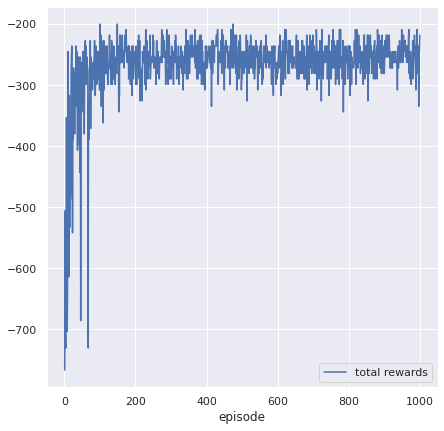

In [ ]:
#Experimenting with hyperparameters
Q3, R3 = Qlearning(env, iterations = 1_000, gamma = 0.5, alpha = 0.01, epsilon = 0.1)
plt.figure(figsize = (7, 7))
plt.plot(range(1, len(R3) + 1), R3, label = "total rewards")
plt.xlabel("episode")
plt.legend()
plt.show()

Episode: 0, Total Reward: -713
Episode: 100, Total Reward: -290
Episode: 200, Total Reward: -245
Episode: 300, Total Reward: -281
Episode: 400, Total Reward: -299
Episode: 500, Total Reward: -236
Episode: 600, Total Reward: -299
Episode: 700, Total Reward: -236
Episode: 800, Total Reward: -236
Episode: 900, Total Reward: -263


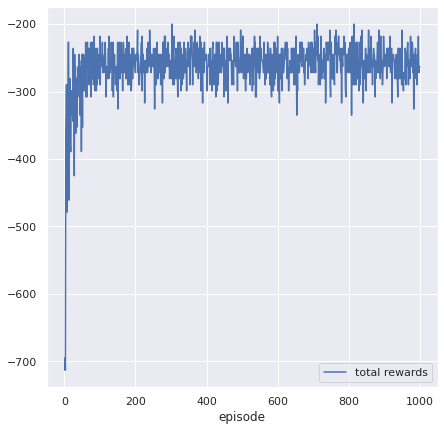

In [ ]:
Q3, R3 = Qlearning(env, iterations = 1_000, gamma = 0.5, alpha = 0.005, epsilon = 0.1)
plt.figure(figsize = (7, 7))
plt.plot(range(1, len(R3) + 1), R3, label = "total rewards")
plt.xlabel("episode")
plt.legend()
plt.show()

Episode: 0, Total Reward: -659
Episode: 100, Total Reward: -236
Episode: 200, Total Reward: -218
Episode: 300, Total Reward: -236
Episode: 400, Total Reward: -236
Episode: 500, Total Reward: -200
Episode: 600, Total Reward: -227
Episode: 700, Total Reward: -236
Episode: 800, Total Reward: -245
Episode: 900, Total Reward: -236


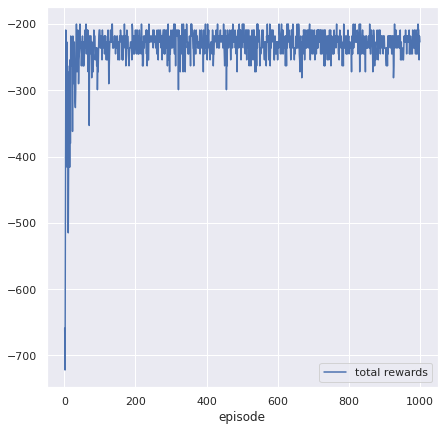

In [ ]:
Q3, R3 = Qlearning(env, iterations = 1_000, gamma = 0.5, alpha = 0.005, epsilon = 0.05)
plt.figure(figsize = (7, 7))
plt.plot(range(1, len(R3) + 1), R3, label = "total rewards")
plt.xlabel("episode")
plt.legend()
plt.show()